# Introducción, objetivos y contenido
========================================================================================================================================

El presente trabajo corresponde a la unidad nro 14 del curso de Data Analytics de TripleTen, denominada "Proyecto Final". El trabajo analizar un servicio de telofonía virtual ("Call Me Maybe") para conocer la eficacia de los operadores. 

Contenidos / Plan de Trabajo:

* Importación de librerías y carga de datos
* Preprocesamiento de datos
    * Verificación de tipo de datos
    * Verificación de duplicados
    * Verificación de nulos
* Análisis de datos (EDA): Identificación de ineficacias
    * Llamadas entrantes perdidas
    * Llamadas salientes
    * Tiempos de espera en llamadas entrantes
    
* Conclusiones

# Importación de librerías y carga de datos
========================================================================================================================================

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, time, date



In [2]:
dfc = pd.read_csv('telecom_clients_us.csv', delimiter = ",")
dfo = pd.read_csv('telecom_dataset_us.csv', delimiter = ",") # registro de operaciones

# Preprocesamiento de datos
========================================================================================================================================

## Dataset CLIENTS

In [3]:
dfc.info()
dfc.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
455,166399,C,2019-08-01
77,167948,C,2019-10-07


In [4]:
# Corrección de tipos de dato
dfc['date_start'] = pd.to_datetime(dfc['date_start'])

dfc.info()
dfc.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
76,166720,C,2019-08-16
432,167318,C,2019-09-11


In [5]:
# Verificación de duplicados
dfc.duplicated().sum()

0

In [6]:
# Verificación de nulos
dfc.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

## Dataset OPERACIONES

In [7]:
print(dfo.info())
dfo.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
27543,167176,2019-09-11 00:00:00+03:00,out,False,905104.0,False,4,622,630
42029,167927,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,15


In [8]:
# Corrección de tipos de dato y agregado de campos

dfo['waiting_time'] = dfo['total_call_duration'] - dfo['call_duration']
dfo['call_duration_unit'] = (dfo['call_duration']/dfo['calls_count']).round(1)
dfo['total_call_duration_unit'] = (dfo['total_call_duration']/dfo['calls_count']).round(1)
dfo['waiting_time_unit'] = (dfo['waiting_time']/dfo['calls_count']).round(1)

dfo['date'] = pd.to_datetime(dfo['date'])
dfo['ymd'] = dfo['date'].dt.strftime('%Y-%m-%d')
dfo['year'] = dfo['date'].dt.year
dfo['month'] = dfo['date'].dt.month
dfo['day'] = dfo['date'].dt.day
dfo['weeknumber'] = dfo['date'].dt.isocalendar().week
dfo['weekday'] = dfo['date'].dt.weekday
dfo['hour'] = dfo['date'].dt.hour
dfo['minute'] = dfo['date'].dt.minute

dfo['internal'] = dfo['internal'].astype(bool)
dfo['is_missed_call'] = dfo['is_missed_call'].astype(bool)

dfo['direction_in'] = dfo['direction'].apply(lambda x: 1 if x == 'in' else 0)
dfo['direction_out'] = dfo['direction'].apply(lambda x: 1 if x == 'out' else 0)
dfo['scope_int'] = dfo['internal'].astype(int)
dfo['scope_ext'] = (~dfo['internal']).astype(int)
dfo['result_missed'] = dfo['is_missed_call'].astype(int)
dfo['result_notmissed'] = (~dfo['is_missed_call']).astype(int)
dfo['in_missed'] = (dfo.apply(lambda row: 1 if row['direction_in'] and row['result_missed'] == 1 else 0, axis=1))*dfo['calls_count']


dfo['direction_in_tot'] = dfo['direction_in']*dfo['calls_count']
dfo['direction_out_tot'] = dfo['direction_out']*dfo['calls_count']
dfo['scope_int_tot'] = dfo['scope_int']*dfo['calls_count']
dfo['scope_ext_tot'] = dfo['scope_ext']*dfo['calls_count']
dfo['result_missed_tot'] = dfo['result_missed']*dfo['calls_count']
dfo['result_notmissed_tot'] = dfo['result_notmissed']*dfo['calls_count']
dfo['in_missed_tot'] = (dfo.apply(lambda row: 1 if row['direction_in'] and row['result_missed'] == 1 else 0, axis=1))*dfo['calls_count']

dfo.info()
dfo.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype                    
---  ------                    --------------  -----                    
 0   user_id                   53902 non-null  int64                    
 1   date                      53902 non-null  datetime64[ns, UTC+03:00]
 2   direction                 53902 non-null  object                   
 3   internal                  53902 non-null  bool                     
 4   operator_id               45730 non-null  float64                  
 5   is_missed_call            53902 non-null  bool                     
 6   calls_count               53902 non-null  int64                    
 7   call_duration             53902 non-null  int64                    
 8   total_call_duration       53902 non-null  int64                    
 9   waiting_time              53902 non-null  int64                    
 10  call_durat

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
2178,166406,2019-11-11 00:00:00+03:00,out,False,879898.0,True,31,0,441,441,...,1,0,0,0,31,0,31,31,0,0
32379,167466,2019-10-14 00:00:00+03:00,in,False,NaN,True,5,0,101,101,...,1,0,5,5,0,0,5,5,0,5


In [9]:
# Verificación de duplicados
dfo.duplicated().sum()

4900

In [10]:
# Eliminación de duplicados
dfo = dfo.drop_duplicates()
dfo.duplicated().sum()

0

In [11]:
# Verificación de nulos
dfo.isna().sum()

user_id                        0
date                           0
direction                      0
internal                       0
operator_id                 7456
is_missed_call                 0
calls_count                    0
call_duration                  0
total_call_duration            0
waiting_time                   0
call_duration_unit             0
total_call_duration_unit       0
waiting_time_unit              0
ymd                            0
year                           0
month                          0
day                            0
weeknumber                     0
weekday                        0
hour                           0
minute                         0
direction_in                   0
direction_out                  0
scope_int                      0
scope_ext                      0
result_missed                  0
result_notmissed               0
in_missed                      0
direction_in_tot               0
direction_out_tot              0
scope_int_

In [12]:
dfo_nulls = dfo[dfo['operator_id'].isna()]
dfo_nulls.sample(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
29346,167235,2019-10-31 00:00:00+03:00,in,False,NaN,True,2,0,76,76,...,1,0,2,2,0,0,2,2,0,2
20660,167004,2019-11-18 00:00:00+03:00,in,False,NaN,True,2,0,16,16,...,1,0,2,2,0,0,2,2,0,2


In [13]:
dfo_nulls['call_duration'].sum()

497685

In [14]:
# Análisis de valores nulos del campo "operator_id"
# Buscaremos algún patrón para ver si es posible conocer los valores nulos del campo operator_id

print(f'Características del dataset con valores nulos en el campo "operator_id: ')
print('------------------------------------------------------------------------')
print(f'Cantidad de operadores únicos: {dfo_nulls['operator_id'].nunique()}')
print(f'Cantidad de usuarios únicos: {dfo_nulls['user_id'].nunique()}')
print(f'Cantidad de fechas únicas: {dfo_nulls['date'].nunique()}')
print(f'Lista de semanas: {dfo_nulls['weeknumber'].unique()}')
print(f'Lista de meses: {dfo_nulls['month'].unique()}')
print(f'Lista de días del mes: {dfo_nulls['day'].unique()}')
print(f'Lista de días de la semana: {dfo_nulls['weekday'].unique()}')
print(f'Suma de duraciones: {dfo_nulls['call_duration'].sum()}')

Características del dataset con valores nulos en el campo "operator_id: 
------------------------------------------------------------------------
Cantidad de operadores únicos: 0
Cantidad de usuarios únicos: 305
Cantidad de fechas únicas: 119
Lista de semanas: <IntegerArray>
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 46, 47]
Length: 18, dtype: UInt32
Lista de meses: [ 8  9 10 11]
Lista de días del mes: [ 4  5  6  7 12 13 14 22 23 24 29  3  9 10 11 16 17  2  8 15 19 20 28 26
 18 27  1 21 30 25 31]
Lista de días de la semana: [6 0 1 2 3 4 5]
Suma de duraciones: 497685


In [15]:
dfo_nulls.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,waiting_time,call_duration_unit,total_call_duration_unit,waiting_time_unit,year,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
count,7456.000000,0.0,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.0,...,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000
mean,167259.123793,NaN,14.024142,66.749598,236.959496,170.209898,5.972116,24.401073,18.428930,2019.0,...,0.984844,0.015156,13.867623,13.954265,0.069877,0.154909,13.869233,13.894716,0.129426,13.867623
std,586.842979,NaN,81.785240,945.349645,1265.307052,842.134635,58.789568,61.832839,21.605769,0.0,...,0.122180,0.122180,81.791869,81.792459,0.877209,1.351755,81.800341,81.787627,1.790732,81.791869
min,166377.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,166782.000000,NaN,1.000000,0.000000,7.000000,7.000000,0.000000,3.000000,2.900000,2019.0,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,167125.000000,NaN,2.000000,0.000000,35.000000,34.000000,0.000000,14.000000,13.800000,2019.0,...,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000
75%,167727.000000,NaN,7.000000,0.000000,115.000000,110.000000,0.000000,28.000000,27.000000,2019.0,...,1.000000,0.000000,6.000000,7.000000,0.000000,0.000000,6.000000,6.000000,0.000000,6.000000
max,168606.000000,NaN,2168.000000,26175.000000,42667.000000,42667.000000,1226.000000,1241.300000,465.000000,2019.0,...,1.000000,1.000000,2168.000000,2168.000000,34.000000,59.000000,2168.000000,2168.000000,52.000000,2168.000000


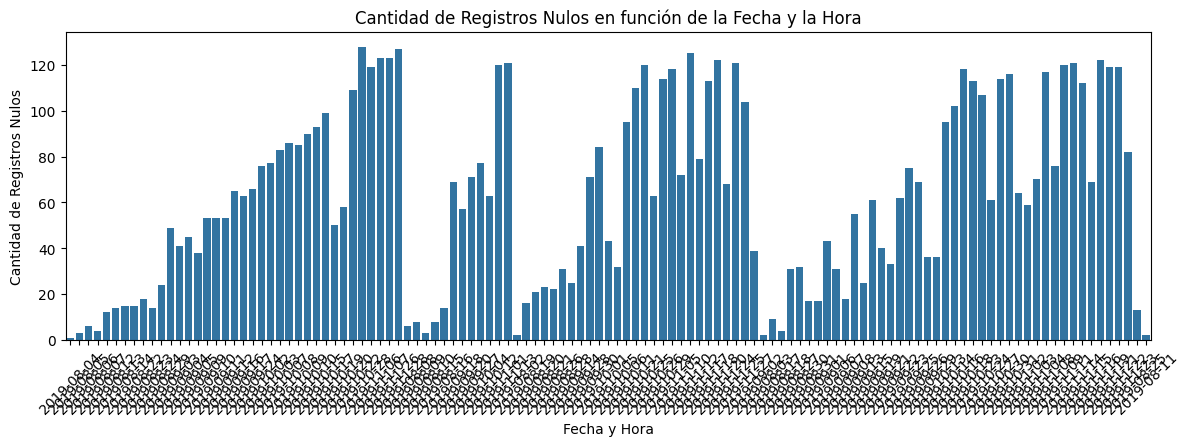

In [16]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='ymd')

plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función de la Fecha y la Hora")

plt.xticks(rotation=45)
plt.show()

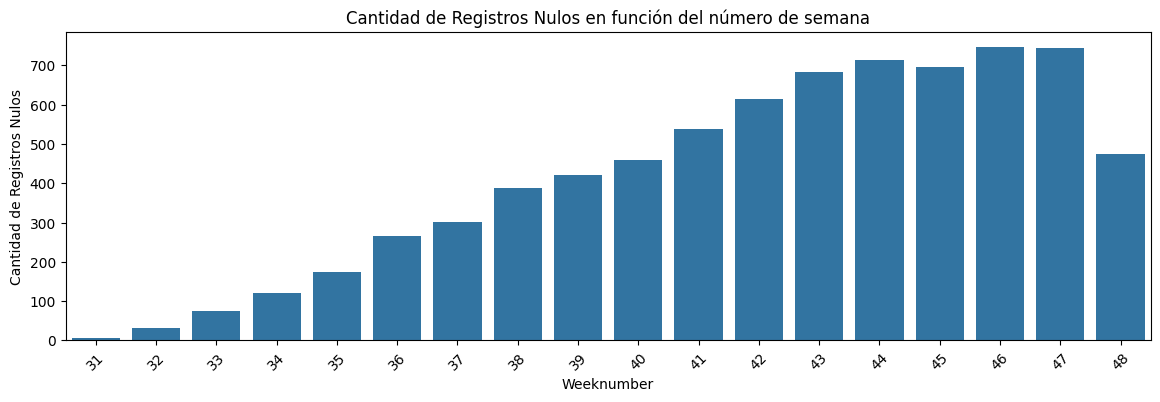

In [17]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='weeknumber')

plt.xlabel("Weeknumber")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función del número de semana")

plt.xticks(rotation=45)
plt.show()

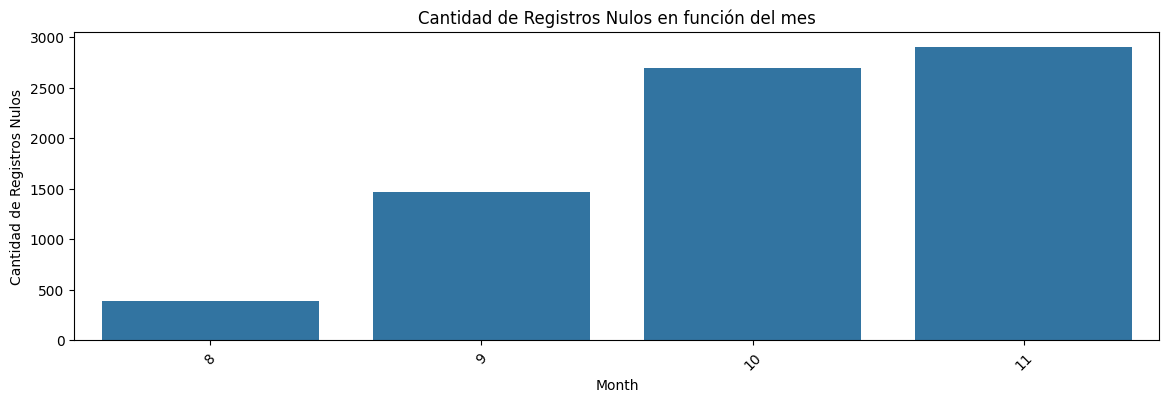

In [18]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='month')

plt.xlabel("Month")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función del mes")

plt.xticks(rotation=45)
plt.show()

* Se observan un total de 7456 registros con valores nulos en el campo "operator_id"
* Hay un total de 1092 operadores que registran trabajos a lo largo de 4 meses
* Se observa que los registros con valores nulos en el campo "operator_id" tiende a aumentar a lo largo de los 4 meses en que se muestra la data.

En función de posiblemente recuperar este valor para aportar información en la búsqueda de ineficiencias, he intentado buscar patrones en los registros para ver si a través de las fechas o los horarios de trabajo, se logra identificar aquellos operadores que no han sido registrados.

* No se logra establecer un patrón para recuperar los valores nulos, habiendo observado:
    * días de semana
    * días del mes
    * semanas
    * meses
    * horario: el dataset no posee este registro, lo cual dificulta la búsqueda de posibles patrones

Debido a ello, se decide eliminar estos valores nulos.

In [19]:
dfo = dfo.dropna(subset=['operator_id'])

dfo.isna().sum()

user_id                     0
date                        0
direction                   0
internal                    0
operator_id                 0
is_missed_call              0
calls_count                 0
call_duration               0
total_call_duration         0
waiting_time                0
call_duration_unit          0
total_call_duration_unit    0
waiting_time_unit           0
ymd                         0
year                        0
month                       0
day                         0
weeknumber                  0
weekday                     0
hour                        0
minute                      0
direction_in                0
direction_out               0
scope_int                   0
scope_ext                   0
result_missed               0
result_notmissed            0
in_missed                   0
direction_in_tot            0
direction_out_tot           0
scope_int_tot               0
scope_ext_tot               0
result_missed_tot           0
result_not

# Análisis de datos (EDA)
===================================================================================================================================

## Ineficiencias en LLAMADAS ENTRANTES PERDIDAS

### Llamadas entrantes perdidas por operador y por fecha

In [20]:
df_in_missed = dfo[dfo['direction']=='in']
df_in_missed = df_in_missed[df_in_missed['is_missed_call']]
df_in_missed_operator_day = df_in_missed.groupby(['operator_id', 'ymd']).agg({'calls_count': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_in_missed_operator_day['calls_count'].describe())
df_in_missed_operator_day.sample(2)

Descripción de la serie
count    683.000000
mean       1.355783
std        1.017836
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       13.000000
Name: calls_count, dtype: float64


,operator_id,ymd,calls_count
505,940588.0,2019-11-14,4
626,944226.0,2019-11-23,1


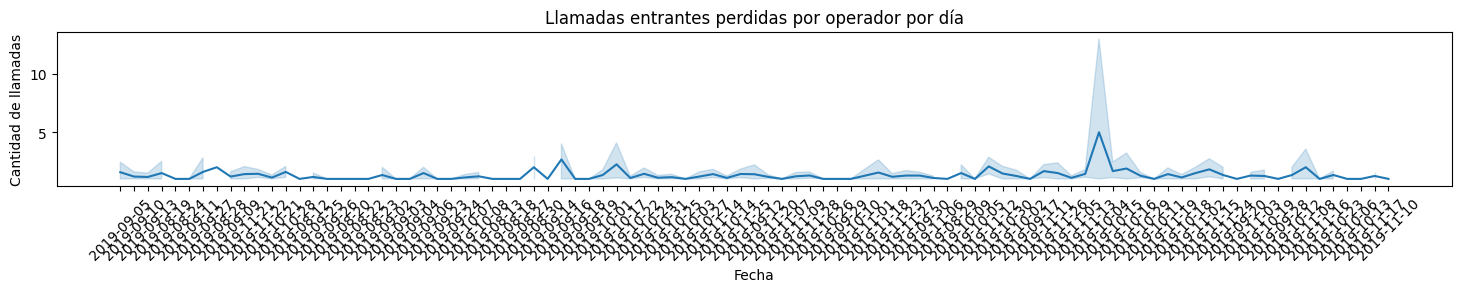

In [21]:
plt.figure(figsize=(18, 2))
sns.lineplot(data=df_in_missed_operator_day, x='ymd', y='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

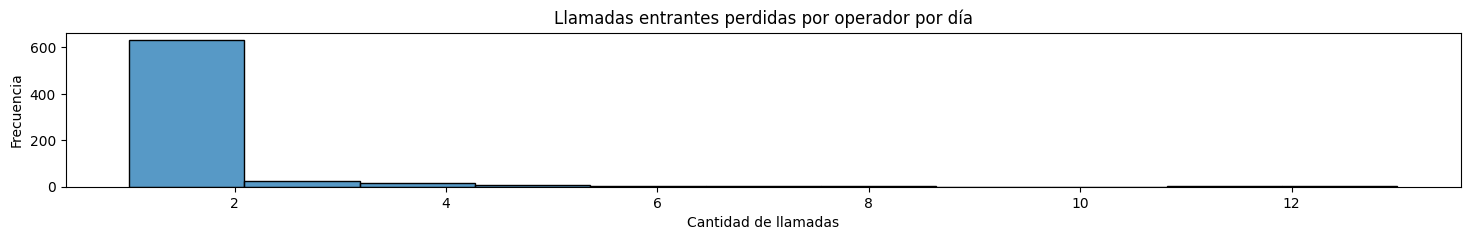

In [22]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_in_missed_operator_day, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

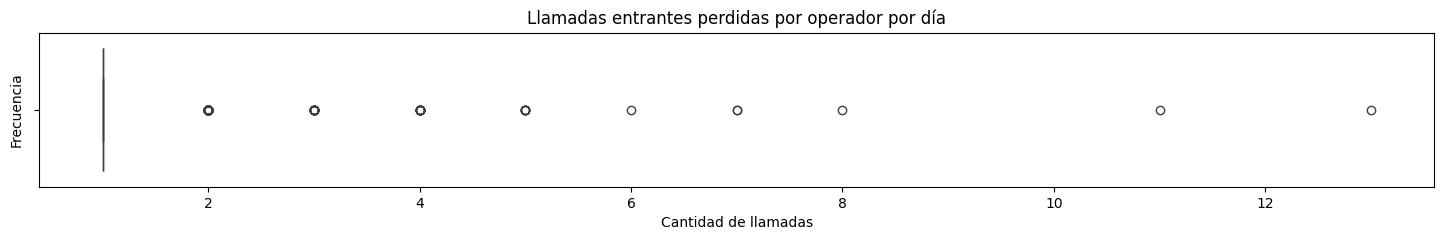

In [23]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_in_missed_operator_day, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* La serie de tiempo se comporta dentro de un rango esperable, aunque también muestra algunas anomalías
* Debido a la naturaleza del proceso, puede esperarse cierto nivel de llamadas perdidas
* Se observa un promedio de 1.35 llamadas perdidas por operador por día, con una mediana de 1.0 desvío estándar de 1.01
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Llamadas entrantes perdidas por operador, totales

In [24]:
df_in_missed = dfo[dfo['direction']=='in']
df_in_missed = df_in_missed[df_in_missed['is_missed_call']]
df_in_missed_operator = df_in_missed.groupby(['operator_id']).agg({'calls_count': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_in_missed_operator['calls_count'].describe())
df_in_missed_operator.sample(2)

Descripción de la serie
count    239.000000
mean       3.874477
std        5.943089
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       52.000000
Name: calls_count, dtype: float64


,operator_id,calls_count
93,912296.0,3
154,933986.0,1


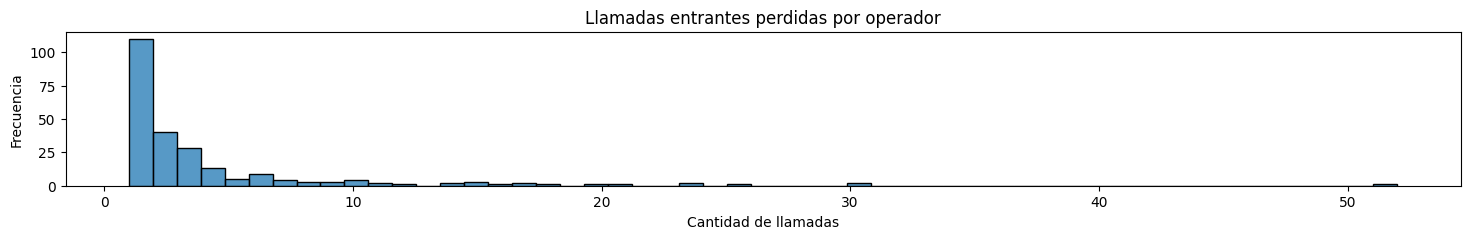

In [25]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_in_missed_operator, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

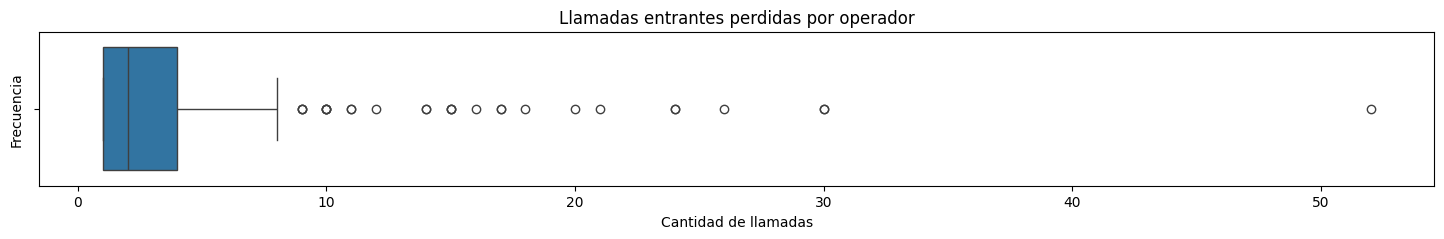

In [26]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_in_missed_operator, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* Se observa un promedio de 3.87 llamadas perdidas por operador por día, con una mediana de 2.0
* El desvío estándar de 5.94 es alto en relación a la media (2 veces mayor)
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Operadores con mayores ineficiencias en llamadas entrantes perdidas

In [27]:
df_in_missed_operator_list = df_in_missed_operator.sort_values(by='calls_count', ascending=False)

df_in_missed_operator_list.head(10)

,operator_id,calls_count
98,913942.0,52
196,940588.0,30
210,944226.0,30
6,885890.0,26
206,944216.0,24
179,937956.0,24
222,951508.0,21
5,885876.0,20
208,944220.0,18
209,944222.0,17


In [28]:
df_in_missed_operator_evolution = df_in_missed.pivot_table(index='operator_id', 
                                                           columns='month', 
                                                           values='calls_count', 
                                                           aggfunc='sum',
                                                           margins=True, margins_name='Total'
                                                           ).reset_index()

df_in_missed_operator_evolution = df_in_missed_operator_evolution.fillna(0)
df_in_missed_operator_evolution = df_in_missed_operator_evolution.sort_values(by='Total', ascending=False)

df_in_missed_operator_evolution = df_in_missed_operator_evolution[df_in_missed_operator_evolution['operator_id'] != 'Total']
df_in_missed_operator_evolution = df_in_missed_operator_evolution.head(10)

In [29]:
df_in_missed_operator_evolution.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 98 to 201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  10 non-null     object 
 1   8            10 non-null     float64
 2   9            10 non-null     float64
 3   10           10 non-null     float64
 4   11           10 non-null     float64
 5   Total        10 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 560.0+ bytes


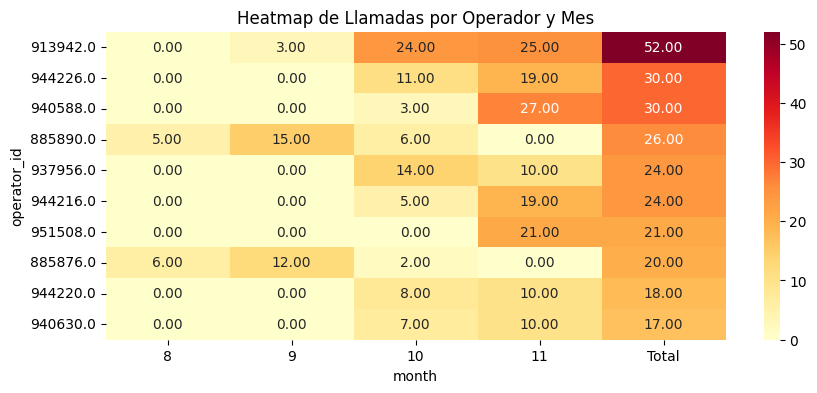

In [30]:
# Establecer 'operator_id' como índice
df_in_missed_operator_evolution.set_index('operator_id', inplace=True)

plt.figure(figsize=(10, 4))
sns.heatmap(df_in_missed_operator_evolution, cmap='YlOrRd', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap de Llamadas por Operador y Mes')
plt.show()

Hallazgos:
* Identificar a los operadores con ineficiencias es importante para poder entrenarlos y ofrecerles la oportunidad de mejorar su calidad de trabajo
* Se debe también conocer la evolución de la performance del trabajador, lo cual resulta muy visible con el mapa de calor


## Ineficiencias en LLAMADAS SALIENTES

### Llamadas salientes por operador y por fecha

In [31]:
df_out = dfo[dfo['direction']=='out']
df_out_operator_day = df_out.groupby(['operator_id', 'ymd']).agg({'calls_count': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_out_operator_day['calls_count'].describe())
df_out_operator_day.sample(2)

Descripción de la serie
count    15113.000000
mean        40.252961
std        126.917420
min          1.000000
25%          3.000000
50%         10.000000
75%         35.000000
max       5022.000000
Name: calls_count, dtype: float64


,operator_id,ymd,calls_count
284,880028.0,2019-09-24,39
206,880026.0,2019-09-25,24


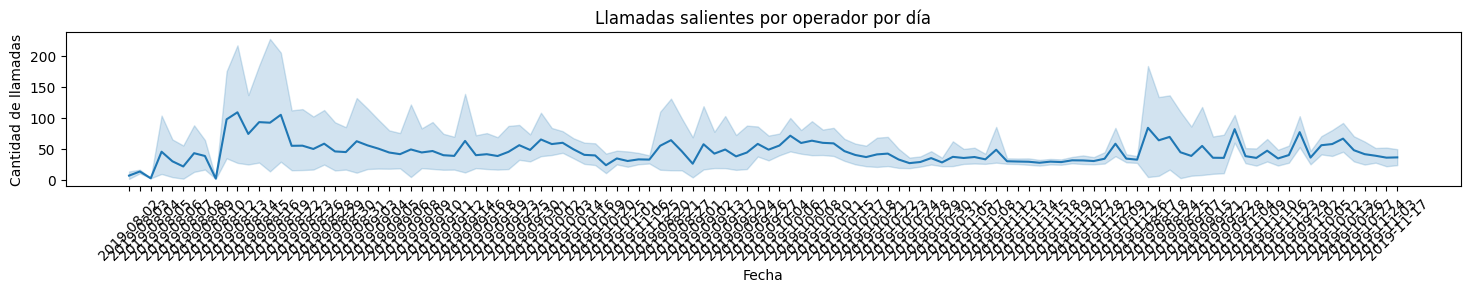

In [32]:
plt.figure(figsize=(18, 2))
sns.lineplot(data=df_out_operator_day, x='ymd', y='calls_count')

plt.title('Llamadas salientes por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

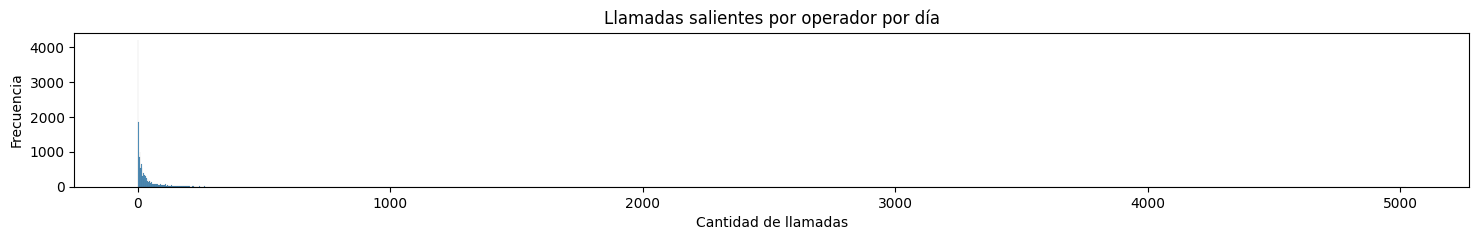

In [33]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_out_operator_day, x='calls_count')

plt.title('Llamadas salientes por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

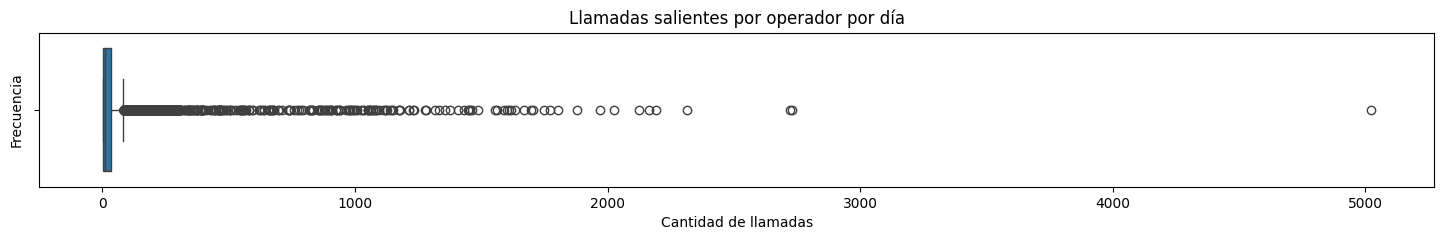

In [34]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_out_operator_day, x='calls_count')

plt.title('Llamadas salientes por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* La serie de tiempo muestra una alta variabilidad, con lo cual es esperable obswervar un desvío estándar alto
* Se observa un promedio de 40.25 llamadas salientes por operador por día, con una mediana de 10.0
* El desvío estándar de 126.91 es muy alto en relación a la media (aproximadamente 4 veces superior)
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Llamadas salientes por operador, totales

In [35]:
df_out = dfo[dfo['direction']=='out']
df_out_operator = df_out.groupby(['operator_id']).agg({'calls_count': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_out_operator['calls_count'].describe())
df_out_operator.sample(2)

Descripción de la serie
count      882.000000
mean       689.731293
std       3122.953946
min          1.000000
25%         11.000000
50%         90.000000
75%        597.250000
max      58977.000000
Name: calls_count, dtype: float64


,operator_id,calls_count
474,930186.0,53
602,939476.0,716


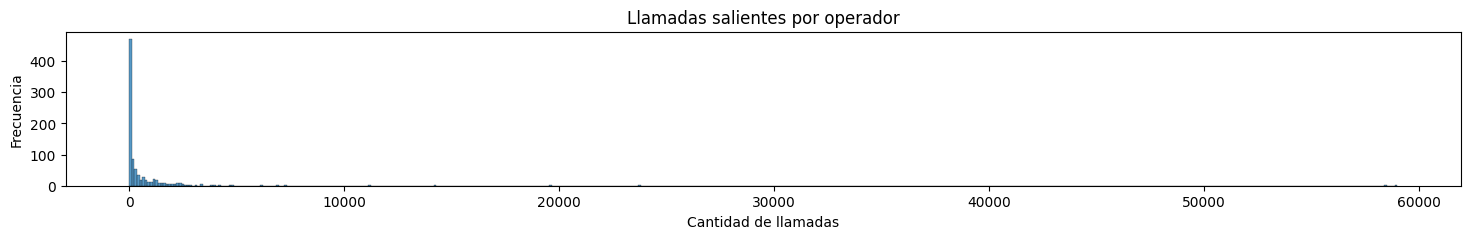

In [36]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_out_operator, x='calls_count')

plt.title('Llamadas salientes por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

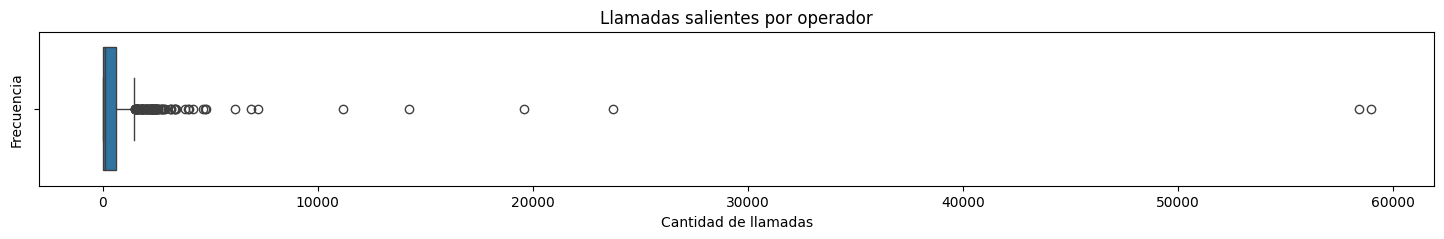

In [37]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_out_operator, x='calls_count')

plt.title('Llamadas salientes por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* Se observa un promedio de 689.73 llamadas salientes por operador, con una mediana de 90.0
* El desvío estándar de 3122.95 es alto en relación a la media (4.5 veces mayor)
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Operadores con mayores ineficiencias en llamadas salientes

In [38]:
df_out_operator_list = df_out_operator.sort_values(by='calls_count', ascending=True)

df_out_operator_list.head(10)

,operator_id,calls_count
793,955086.0,1
841,963716.0,1
293,914272.0,1
495,932246.0,1
168,902238.0,1
653,941816.0,1
853,966686.0,1
654,941826.0,1
102,895266.0,1
545,937720.0,1


In [39]:
df_out_operator_evolution = df_out.pivot_table(index='operator_id', 
                                                           columns='month', 
                                                           values='calls_count', 
                                                           aggfunc='sum',
                                                           margins=True, margins_name='Total'
                                                           ).reset_index()

df_out_operator_evolution = df_out_operator_evolution.fillna(0)
df_out_operator_evolution = df_out_operator_evolution.sort_values(by='Total', ascending=True)

df_out_operator_evolution = df_out_operator_evolution[df_out_operator_evolution['operator_id'] != 'Total']
df_out_operator_evolution = df_out_operator_evolution.head(20)

In [40]:
print(df_out_operator_evolution.info())
df_out_operator_evolution

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 710 to 782
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  20 non-null     object 
 1   8            20 non-null     float64
 2   9            20 non-null     float64
 3   10           20 non-null     float64
 4   11           20 non-null     float64
 5   Total        20 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ KB
None


month,operator_id,8,9,10,11,Total
710,946072.0,0.0,0.0,0.0,1.0,1
335,918988.0,0.0,0.0,1.0,0.0,1
556,937778.0,0.0,0.0,0.0,1.0,1
554,937772.0,0.0,0.0,1.0,0.0,1
553,937770.0,0.0,0.0,0.0,1.0,1
814,958458.0,0.0,0.0,0.0,1.0,1
350,919206.0,0.0,1.0,0.0,0.0,1
351,919214.0,0.0,1.0,0.0,0.0,1
545,937720.0,0.0,0.0,1.0,0.0,1
544,937716.0,0.0,0.0,0.0,1.0,1


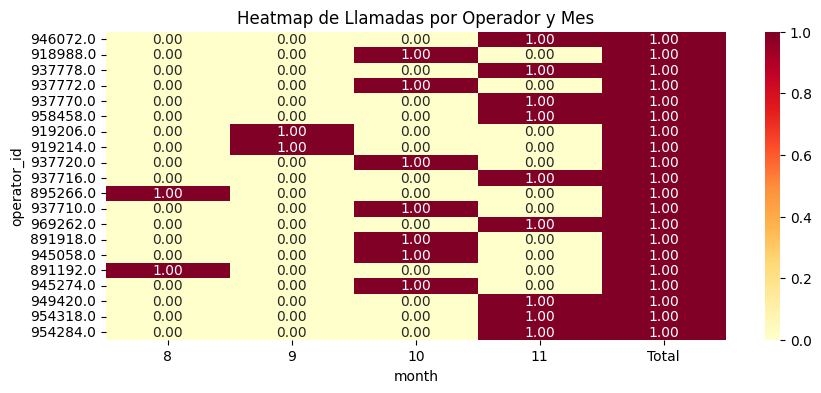

In [41]:
# Establecer 'operator_id' como índice
df_out_operator_evolution.set_index('operator_id', inplace=True)

plt.figure(figsize=(10, 4))
sns.heatmap(df_out_operator_evolution, cmap='YlOrRd', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap de Llamadas por Operador y Mes')
plt.show()

## Ineficiencias en TIEMPO DE ESPERA DE LLAMADAS ENTRANTES

### Tiempo de espera de llamadas entrantes por operador y por fecha

In [42]:
df_in = dfo[dfo['direction']=='in']
df_in_wait_operator_day = df_in.groupby(['operator_id', 'ymd']).agg({'waiting_time': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_in_wait_operator_day['waiting_time'].describe())
df_in_wait_operator_day.sample(2)

Descripción de la serie
count    11781.000000
mean       104.684237
std        193.307347
min          0.000000
25%         18.000000
50%         42.000000
75%        105.000000
max       3998.000000
Name: waiting_time, dtype: float64


,operator_id,ymd,waiting_time
5054,907994.0,2019-09-17,26
7449,921818.0,2019-11-01,173


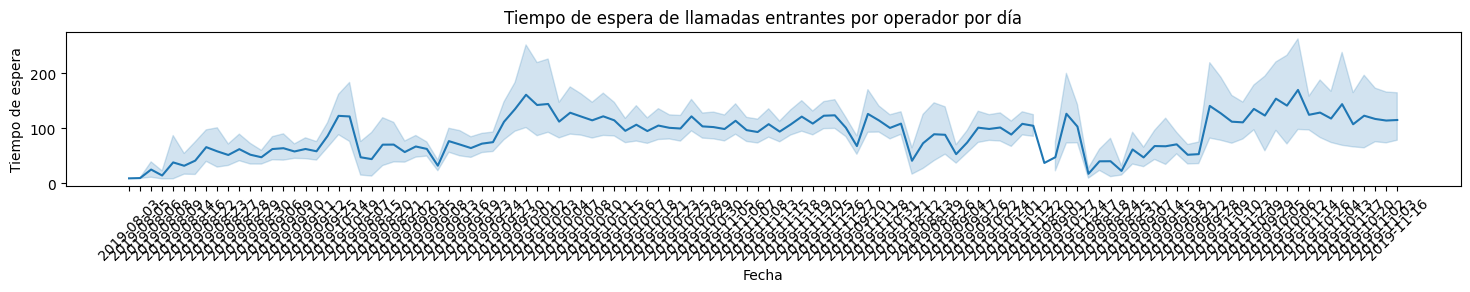

In [43]:
plt.figure(figsize=(18, 2))
sns.lineplot(data=df_in_wait_operator_day, x='ymd', y='waiting_time')

plt.title('Tiempo de espera de llamadas entrantes por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de espera')
plt.xticks(rotation=45)
plt.show()

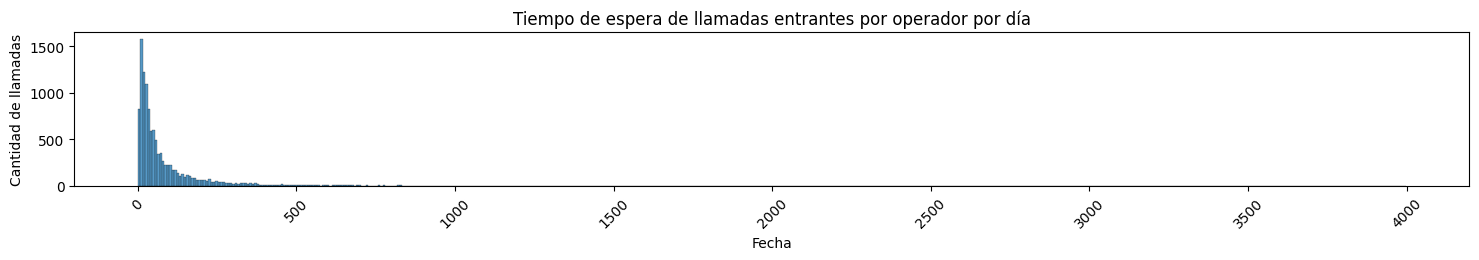

In [44]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_in_wait_operator_day, x='waiting_time')

plt.title('Tiempo de espera de llamadas entrantes por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

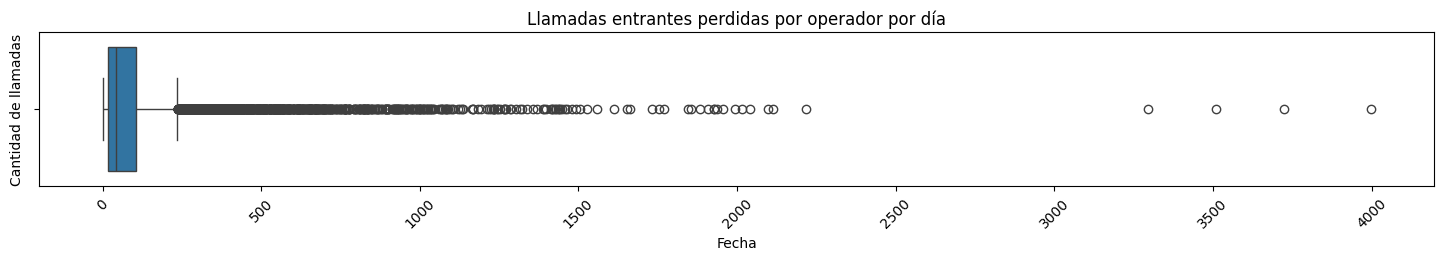

In [45]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_in_wait_operator_day, x='waiting_time')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

Hallazgos:
* La serie de tiempo muestra cierta estabilidad en una etapa intermedia, pero en las etapas iniciales y finales se muestra muy variable
* Se observa un promedio de 104.68 de tiempo de espera por operador por día, con una mediana de 42.0 desvío estándar de 193.30
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Tiempo de espera de llamadas entrantes por operador, totales

In [46]:
df_in = dfo[dfo['direction']=='in']
df_in_wait_operator = df_in.groupby(['operator_id']).agg({'waiting_time': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_in_wait_operator['waiting_time'].describe())
df_in_wait_operator.sample(2)

Descripción de la serie
count      754.000000
mean      1635.656499
std       4637.607919
min          1.000000
25%         62.000000
50%        255.000000
75%       1064.250000
max      52875.000000
Name: waiting_time, dtype: float64


,operator_id,waiting_time
348,920838.0,760
205,905934.0,9


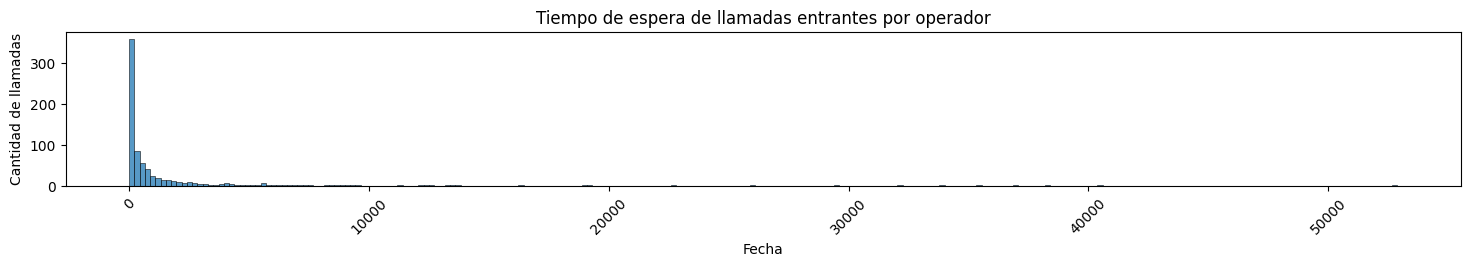

In [47]:
plt.figure(figsize=(18, 2))
sns.histplot(data=df_in_wait_operator, x='waiting_time')

plt.title('Tiempo de espera de llamadas entrantes por operador')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

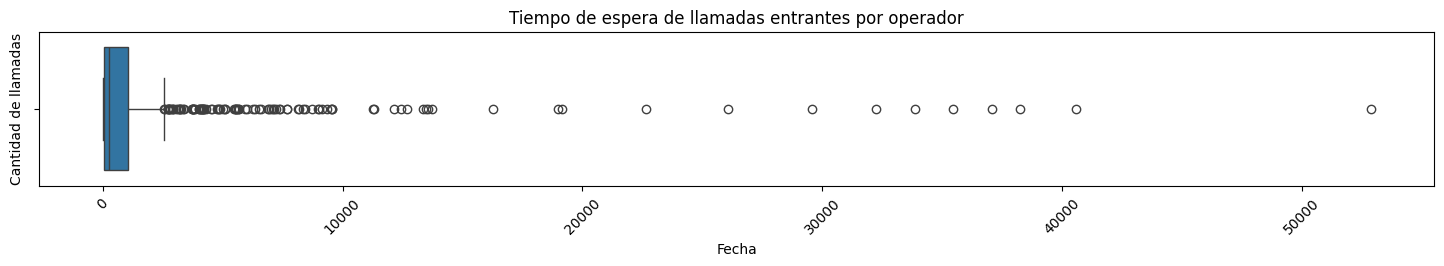

In [48]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=df_in_wait_operator, x='waiting_time')

plt.title('Tiempo de espera de llamadas entrantes por operador')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

Hallazgos:
* Se observa un promedio de 1635.65 de tiempo de espera por operador, con una mediana de 255.0 desvío estándar de 4637.60
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Operadores con mayores ineficiencias en sus tiempos de espera

In [49]:
df_in_wait_operator_list = df_in_wait_operator.sort_values(by='waiting_time', ascending=False)

df_in_wait_operator_list.head(10)

,operator_id,waiting_time
335,919790.0,52875
288,913938.0,40577
334,919554.0,38240
333,919552.0,37076
445,931458.0,35462
358,921318.0,33848
337,919794.0,32236
289,913942.0,29573
252,908958.0,26062
336,919792.0,22642


In [50]:
df_in_wait_operator_evolution = df_in.pivot_table(index='operator_id', 
                                                           columns='month', 
                                                           values='waiting_time', 
                                                           aggfunc='sum',
                                                           margins=True, margins_name='Total'
                                                           ).reset_index()

df_in_wait_operator_evolution = df_in_wait_operator_evolution.fillna(0)
df_in_wait_operator_evolution = df_in_wait_operator_evolution.sort_values(by='Total', ascending=False)

df_in_wait_operator_evolution = df_in_wait_operator_evolution[df_in_wait_operator_evolution['operator_id'] != 'Total']
df_in_wait_operator_evolution = df_in_wait_operator_evolution.head(10)

In [51]:
print(df_in_wait_operator_evolution.info())
df_in_wait_operator_evolution

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 335 to 336
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  10 non-null     object 
 1   8            10 non-null     float64
 2   9            10 non-null     float64
 3   10           10 non-null     float64
 4   11           10 non-null     float64
 5   Total        10 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 560.0+ bytes
None


month,operator_id,8,9,10,11,Total
335,919790.0,0.0,3686.0,21820.0,27369.0,52875
288,913938.0,0.0,2857.0,21071.0,16649.0,40577
334,919554.0,0.0,991.0,20489.0,16760.0,38240
333,919552.0,0.0,923.0,18458.0,17695.0,37076
445,931458.0,0.0,0.0,10758.0,24704.0,35462
358,921318.0,0.0,0.0,12778.0,21070.0,33848
337,919794.0,0.0,2660.0,19135.0,10441.0,32236
289,913942.0,0.0,3220.0,15808.0,10545.0,29573
252,908958.0,0.0,7740.0,11883.0,6439.0,26062
336,919792.0,0.0,1998.0,11365.0,9279.0,22642


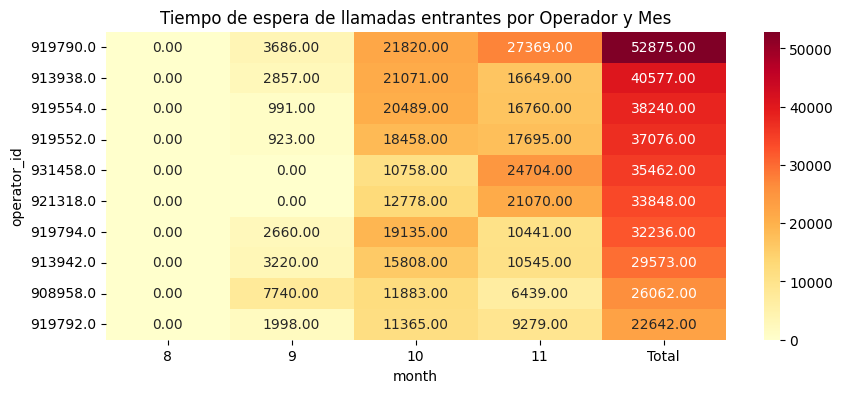

In [52]:
# Establecer 'operator_id' como índice
df_in_wait_operator_evolution.set_index('operator_id', inplace=True)

plt.figure(figsize=(10, 4))
sns.heatmap(df_in_wait_operator_evolution, cmap='YlOrRd', annot=True, fmt='.2f', cbar=True)
plt.title('Tiempo de espera de llamadas entrantes por Operador y Mes')
plt.show()

# Conclusiones y Recomendaciones
================================================================================================================================

Se definen un total de 3 criterios para det4erminar las ineficiencias en el call center:
* ALTA cantidad de LLAMADAS ENTRANTES PERDIDAS
* BAJA cantidad de LLAMADAS SALIENTES
* ALTO tiempo de espera de LLAMADAS ENTRANTES

Se revisaron para cada uno de los criterios:
* Serie de tiempo y distribución por operador y por fecha
* Distribución por operador
* Identificación de operadores con mayores ineficiencias